In [1]:
# (token方向に)AvgPool -> (embed方向に)LayerNorm
# 0.1はwarmup
# gradient_accumulation_steps = 2
# anferico/bert-for-patents

Credits to: https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-w-w-b-train and https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

I just applied Abhishek's great code to Nakama's great notebook to create folds grouped by anchors and stratified by score. Does this close the CV-LB gap? Let's see :-)

# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [2]:
# ====================================================
# CFG
# ====================================================
class CFG:
    
    # General
    exp='033'
    debug=False  # False
    wandb=True
    resume= None  # [None, 'auto', 'allow', 'must']
    save_checkpoint=True
    competition='PPPM'
    seed=42

    # Dataset & DataLoader
    tokenizer_kwargs={
        'do_lower_case': True,
    }
    num_workers=4
    batch_size=16
    max_len=512

    # Model
    model="anferico/bert-for-patents"
    fc_dropout=0.2
    target_size=1

    # Optimizer & Scheduler
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    weight_decay=0.01
    max_grad_norm=1000

    # Train
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    epochs=5
    gradient_accumulation_steps=2
    print_freq=100
    apex=True
    train=True
    

if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]


# ====================================================
# Colab settings
# ====================================================
class ColabConfig:
    dataset_name = CFG.competition
    dataset_version = 'exp' + CFG.exp
    dataset_new = True  # 新しいデータセットか
    dataset_dir = None  # Kaggle Dataset にアップロードするディレクトリ
    dataset_note = ''  # 前の版からの変更点
    in_colab = False  # colab上にデータダウンロード

In [3]:
!nvcc --version
!python -c 'import torch; print(torch.__version__) '
!python --version
print('')
!nvidia-smi
print('')
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
1.11.0+cu113
Python 3.7.13

Sat Jun 18 14:24:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                

In [4]:
%%time
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
    import os
    print('This environment is Google Colab')

    # mount drive
    from google.colab import drive
    if not os.path.isdir('/content/drive'):
        drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/kaggle/PPPM/exps')

    # kaggle api token and update kaggle api
    from google.colab import files
    if not os.path.isfile('~/.kaggle/kaggle.json'):
        # files.upload()
        !mkdir -p ~/.kaggle
        !cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        !pip install --upgrade --force-reinstall --no-deps -q kaggle

    if ColabConfig.in_colab:
        # make directory in colab
        !mkdir -p /content/input
        !mkdir -p /content/working

        # download dataset in colab
        import zipfile, glob
        os.chdir('/content/input')
        # !kaggle competitions download -qc birdclef-2022 -p birdclef-2022
        
        # !mkdir birdclef-2022
        # !cp /content/drive/MyDrive/kaggle/BirdCLEF2022/input/birdclef-2022/* ./birdclef-2022/

        for p in glob.glob('**/*.zip', recursive=True):
            print(p)
            d, f = os.path.split(p)
            # if f in ['']:
            #     continue
            with zipfile.ZipFile(p, 'r') as zipf:
                print('unzip: ', zipf)
                zipf.extractall(d)
                print('remove: ', f)
                os.remove(p)
        
        os.chdir('/content/working')

This environment is Google Colab
Mounted at /content/drive
     |████████████████████████████████| 58 kB 6.0 MB/s 
CPU times: user 1.08 s, sys: 229 ms, total: 1.31 s
Wall time: 23.8 s


In [5]:
# ====================================================
# Directory settings
# ====================================================
import os

INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
OUTPUT_DIR = f'/content/drive/MyDrive/kaggle/PPPM/output/{CFG.exp}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# kaggle dataset config
ColabConfig.dataset_dir = OUTPUT_DIR

# WandB

In [6]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    !pip install -q wandb
    import wandb

    if CFG.debug:
        anony = "must"
        print('It is debugging.')
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')
    else:
        try:
            # from kaggle_secrets import UserSecretsClient
            # user_secrets = UserSecretsClient()
            # secret_value_0 = user_secrets.get_secret("wandb_api")
            with open('/content/drive/MyDrive/kaggle/wandb') as f:
                wandb_api_key = f.readline().rstrip('\n')
            wandb.login(key=wandb_api_key)
            anony = None
        except:
            anony = "must"
            print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    # https://docs.wandb.ai/ref/python/init
    run = wandb.init(project='PPPM', 
                        name=CFG.exp,
                        config=class2dict(CFG),
                    #  group=CFG.exp,
                        job_type="train",
                        resume=CFG.resume,  # 'auto'
                        # id='3bwalqa8',
                        anonymous=anony)

     |████████████████████████████████| 1.8 MB 16.3 MB/s 
     |████████████████████████████████| 181 kB 74.1 MB/s 
     |████████████████████████████████| 145 kB 73.9 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: y-haneji. Use `wandb login --relogin` to force relogin


# Library

In [7]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
tqdm.pandas()
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

# # 20分ぐらい
# !pip uninstall -y torch torchvision
# !pip install 'https://download.pytorch.org/whl/cu111/torch-1.10.2%2Bcu111-cp37-cp37m-linux_x86_64.whl' 'https://download.pytorch.org/whl/cu111/torchvision-0.11.3%2Bcu111-cp37-cp37m-linux_x86_64.whl'
# !git clone https://github.com/NVIDIA/apex.git
# %cd apex
# !pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .
# %cd ..
# # !rm -rf /content/drive/MyDrive/kaggle/PPPM/exps/apex/
# from apex import amp

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('python -m pip install sentencepiece')
os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels tokenizers')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [8]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [9]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [10]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [11]:
# ';' を ',' に変換する
def preprocess_context(text: str):
    text = text.replace(';', '.')
    return text

train['context_text'] = train['context_text'].map(preprocess_context)
test['context_text'] = test['context_text'].map(preprocess_context)

In [12]:
# anchor, target, context_text をそれぞれ一文ずつとみなす
# anchorとtarget逆順にも並べる
train['text'] = train['anchor'] + '.' + ' [SEP] ' + train['target'] + '.' + ' [SEP] '  + train['context_text'] + '.'
test['text'] = test['anchor'] + '.' + ' [SEP] ' + test['target'] + '.' + ' [SEP] '  + test['context_text'] + '.'
train['text_rev'] = train['target'] + '.' + ' [SEP] ' + train['anchor'] + '.' + ' [SEP] '  + train['context_text'] + '.'
test['text_rev'] = test['target'] + '.' + ' [SEP] ' + test['anchor'] + '.' + ' [SEP] '  + test['context_text'] + '.'
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text,text_rev
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] abatement of pollution. [SEP]...,abatement of pollution. [SEP] abatement. [SEP]...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] act of abating. [SEP] HUMAN N...,act of abating. [SEP] abatement. [SEP] HUMAN N...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] active catalyst. [SEP] HUMAN ...,active catalyst. [SEP] abatement. [SEP] HUMAN ...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] eliminating process. [SEP] HU...,eliminating process. [SEP] abatement. [SEP] HU...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] forest region. [SEP] HUMAN NE...,forest region. [SEP] abatement. [SEP] HUMAN NE...


,id,anchor,target,context,context_text,text,text_rev
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum. [SEP] inorganic photoconductor drum....,inorganic photoconductor drum. [SEP] opc drum....
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING. LIGHTING. HEATING. WEA...,adjust gas flow. [SEP] altering gas flow. [SEP...,altering gas flow. [SEP] adjust gas flow. [SEP...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS. TRANSPORTING. VEHICLES ...,lower trunnion. [SEP] lower locating. [SEP] PE...,lower locating. [SEP] lower trunnion. [SEP] PE...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES. PAPER. TREATMENT OF TEXTILES OR THE ...,cap component. [SEP] upper portion. [SEP] TEXT...,upper portion. [SEP] cap component. [SEP] TEXT...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation. [SEP] artificial neural ne...,artificial neural network. [SEP] neural stimul...


# EDA

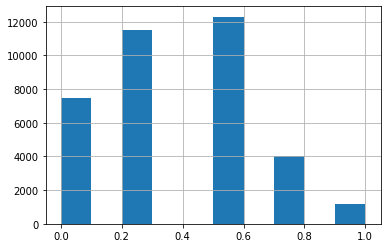

In [13]:
train['score'].hist()

In [14]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [15]:
#credits to: https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

!pip install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
print(train.fold.value_counts())

550 183
549 184
550 183
550 183
3    9622
0    9379
1    8860
2    8612
Name: fold, dtype: int64


In [16]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [17]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model, **CFG.tokenizer_kwargs)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Downloading:   0%|          | 0.00/327 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/322k [00:00<?, ?B/s]

# Dataset

In [18]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 117


In [19]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df, phase: str ='train'):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [20]:
# train_dataset = TrainDataset(CFG, train, 'train')
# inputs, label = train_dataset[0]
# print(inputs)
# print(label)

# Model

In [21]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self.layer_norm1 = nn.LayerNorm(self.config.hidden_size)
        self._init_weights(self.attention)
        self.linear = nn.Linear(self.config.hidden_size, 1)
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_state = outputs[0]
        input_mask_expanded = inputs["attention_mask"].unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        out = sum_embeddings / sum_mask
        
        out = self.layer_norm1(out)
        output = self.fc(out)
                
        return output

# Helpler functions

In [22]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [23]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold, checkpoint_path=None,):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds, phase='train')
    valid_dataset = TrainDataset(CFG, valid_folds, phase='val')

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size / CFG.gradient_accumulation_steps * CFG.epochs)
    CFG.num_warmup_steps = num_train_steps * 0.1
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.
    epoch = 0

    # if wandb.run.resumed:
    #     checkpoint = torch.load(checkpoint_path)  # wandb.restore(checkpoint_path)
    #     if checkpoint['epoch'] < CFG.epochs-1:  # foldの終わりで止まっている時もある
    #         model.load_state_dict(checkpoint['model'])
    #         optimizer.load_state_dict(checkpoint['optimizer'])
    #         scheduler.load_state_dict(checkpoint['scheduler'])
    #         # amp.load_state_dict(checkpoint['amp'])
    #         epoch = checkpoint['epoch'] + 1  # 保存時のエポックが読み出されるので+1
    #         best_score = checkpoint['best_score']

    while epoch < CFG.epochs:
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if CFG.save_checkpoint:
            torch.save({'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'scheduler': scheduler.state_dict(),
                        # 'amp': amp.state_dict(),
                        'epoch': epoch,
                        'best_score': best_score},
                        checkpoint_path)
            # wandb.save(checkpoint_path)  # driveでos.symlinkでエラーが出る

        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
            
        epoch += 1

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [24]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        fold = 0

        if wandb.run.resumed:
            checkpoint = torch.load(OUTPUT_DIR + 'fold_checkpoint.pth')
            fold = checkpoint['fold'] + 1  # 保存時のfoldが読み出されるので+1
            oof_df = checkpoint['oof_df']

        while fold < CFG.n_fold:
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold, checkpoint_path=OUTPUT_DIR + 'epoch_checkpoint.pth')
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
            if CFG.save_checkpoint:
                torch.save({'fold': fold,
                            'oof_df': oof_df},
                            OUTPUT_DIR + 'fold_checkpoint.pth')
            fold += 1

        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb & (~CFG.debug):
        wandb.finish()

    os.remove(OUTPUT_DIR + 'fold_checkpoint.pth')
    os.remove(OUTPUT_DIR + 'epoch_checkpoint.pth')

========== fold: 0 training ==========


Downloading:   0%|          | 0.00/1.29G [00:00<?, ?B/s]

Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1693] Elapsed 0m 0s (remain 22m 37s) Loss: 0.3679(0.3679) Grad: inf  LR: 0.00000000  
Epoch: [1][100/1693] Elapsed 1m 2s (remain 16m 26s) Loss: 0.2826(0.3458) Grad: 32912.8789  LR: 0.00000236  
Epoch: [1][200/1693] Elapsed 2m 4s (remain 15m 21s) Loss: 0.3042(0.3366) Grad: 25247.3281  LR: 0.00000472  
Epoch: [1][300/1693] Elapsed 3m 5s (remain 14m 19s) Loss: 0.3652(0.3332) Grad: 75625.4531  LR: 0.00000709  
Epoch: [1][400/1693] Elapsed 4m 7s (remain 13m 16s) Loss: 0.2531(0.3292) Grad: 41591.7656  LR: 0.00000945  
Epoch: [1][500/1693] Elapsed 5m 8s (remain 12m 15s) Loss: 0.3291(0.3261) Grad: 59211.2891  LR: 0.00001181  
Epoch: [1][600/1693] Elapsed 6m 10s (remain 11m 13s) Loss: 0.2917(0.3224) Grad: 43317.3203  LR: 0.00001417  
Epoch: [1][700/1693] Elapsed 7m 12s (remain 10m 11s) Loss: 0.3021(0.3188) Grad: 50723.6602  LR: 0.00001654  
Epoch: [1][800/1693] Elapsed 8m 13s (remain 9m 9s) Loss: 0.2406(0.3152) Grad: 16761.6797  LR: 0.00001890  
Epoch: [1][900/1693] Elapsed 9m 15s 

Epoch 1 - avg_train_loss: 0.2997  avg_val_loss: 0.2789  time: 1170s
Epoch 1 - Score: 0.7940


EVAL: [586/587] Elapsed 2m 6s (remain 0m 0s) Loss: 0.3492(0.2789) 


Epoch 1 - Save Best Score: 0.7940 Model


Epoch: [2][0/1693] Elapsed 0m 0s (remain 24m 26s) Loss: 0.3020(0.3020) Grad: 97274.1719  LR: 0.00001940  
Epoch: [2][100/1693] Elapsed 1m 3s (remain 16m 39s) Loss: 0.2820(0.2775) Grad: 142793.8125  LR: 0.00001925  
Epoch: [2][200/1693] Elapsed 2m 5s (remain 15m 27s) Loss: 0.2919(0.2732) Grad: 108773.0859  LR: 0.00001909  
Epoch: [2][300/1693] Elapsed 3m 6s (remain 14m 22s) Loss: 0.2930(0.2730) Grad: 13602.3076  LR: 0.00001891  
Epoch: [2][400/1693] Elapsed 4m 8s (remain 13m 19s) Loss: 0.2534(0.2714) Grad: 36549.2852  LR: 0.00001871  
Epoch: [2][500/1693] Elapsed 5m 9s (remain 12m 17s) Loss: 0.2700(0.2714) Grad: 25734.9805  LR: 0.00001850  
Epoch: [2][600/1693] Elapsed 6m 11s (remain 11m 14s) Loss: 0.3054(0.2727) Grad: 11532.8887  LR: 0.00001828  
Epoch: [2][700/1693] Elapsed 7m 12s (remain 10m 12s) Loss: 0.3134(0.2726) Grad: 59940.2305  LR: 0.00001804  
Epoch: [2][800/1693] Elapsed 8m 14s (remain 9m 10s) Loss: 0.3152(0.2720) Grad: 136290.2500  LR: 0.00001779  
Epoch: [2][900/1693] Elap

Epoch 2 - avg_train_loss: 0.2710  avg_val_loss: 0.2727  time: 1170s
Epoch 2 - Score: 0.8223


EVAL: [586/587] Elapsed 2m 5s (remain 0m 0s) Loss: 0.3490(0.2727) 


Epoch 2 - Save Best Score: 0.8223 Model


Epoch: [3][0/1693] Elapsed 0m 0s (remain 25m 40s) Loss: 0.2649(0.2649) Grad: 62123.9570  LR: 0.00001501  
Epoch: [3][100/1693] Elapsed 1m 2s (remain 16m 31s) Loss: 0.2703(0.2591) Grad: 116516.7969  LR: 0.00001465  
Epoch: [3][200/1693] Elapsed 2m 4s (remain 15m 25s) Loss: 0.2811(0.2617) Grad: 105307.2812  LR: 0.00001428  
Epoch: [3][300/1693] Elapsed 3m 6s (remain 14m 21s) Loss: 0.3067(0.2632) Grad: 41926.4180  LR: 0.00001390  
Epoch: [3][400/1693] Elapsed 4m 7s (remain 13m 18s) Loss: 0.2807(0.2637) Grad: 74025.1797  LR: 0.00001352  
Epoch: [3][500/1693] Elapsed 5m 9s (remain 12m 16s) Loss: 0.1841(0.2641) Grad: 48509.8398  LR: 0.00001313  
Epoch: [3][600/1693] Elapsed 6m 11s (remain 11m 14s) Loss: 0.2599(0.2631) Grad: 61214.2305  LR: 0.00001274  
Epoch: [3][700/1693] Elapsed 7m 12s (remain 10m 12s) Loss: 0.2290(0.2620) Grad: 50175.8047  LR: 0.00001234  
Epoch: [3][800/1693] Elapsed 8m 14s (remain 9m 10s) Loss: 0.2050(0.2617) Grad: 51525.3359  LR: 0.00001194  
Epoch: [3][900/1693] Elaps

Epoch 3 - avg_train_loss: 0.2616  avg_val_loss: 0.2755  time: 1169s
Epoch 3 - Score: 0.8264


EVAL: [586/587] Elapsed 2m 4s (remain 0m 0s) Loss: 0.3448(0.2755) 


Epoch 3 - Save Best Score: 0.8264 Model


Epoch: [4][0/1693] Elapsed 0m 0s (remain 26m 37s) Loss: 0.2711(0.2711) Grad: 32161.3281  LR: 0.00000828  
Epoch: [4][100/1693] Elapsed 1m 3s (remain 16m 36s) Loss: 0.3114(0.2555) Grad: 41543.9609  LR: 0.00000787  
Epoch: [4][200/1693] Elapsed 2m 5s (remain 15m 27s) Loss: 0.3197(0.2580) Grad: 84515.6797  LR: 0.00000747  
Epoch: [4][300/1693] Elapsed 3m 6s (remain 14m 22s) Loss: 0.2454(0.2581) Grad: 71776.6484  LR: 0.00000708  
Epoch: [4][400/1693] Elapsed 4m 8s (remain 13m 19s) Loss: 0.1566(0.2586) Grad: 22077.6953  LR: 0.00000668  
Epoch: [4][500/1693] Elapsed 5m 9s (remain 12m 16s) Loss: 0.3290(0.2579) Grad: 177674.1562  LR: 0.00000630  
Epoch: [4][600/1693] Elapsed 6m 11s (remain 11m 14s) Loss: 0.2887(0.2577) Grad: 92318.3281  LR: 0.00000592  
Epoch: [4][700/1693] Elapsed 7m 12s (remain 10m 12s) Loss: 0.2173(0.2579) Grad: 20223.5781  LR: 0.00000555  
Epoch: [4][800/1693] Elapsed 8m 14s (remain 9m 10s) Loss: 0.2449(0.2583) Grad: 45860.0430  LR: 0.00000518  
Epoch: [4][900/1693] Elapse

Epoch 4 - avg_train_loss: 0.2574  avg_val_loss: 0.2738  time: 1169s
Epoch 4 - Score: 0.8324


EVAL: [586/587] Elapsed 2m 5s (remain 0m 0s) Loss: 0.3545(0.2738) 


Epoch 4 - Save Best Score: 0.8324 Model


Epoch: [5][0/1693] Elapsed 0m 1s (remain 29m 59s) Loss: 0.2465(0.2465) Grad: 25406.6250  LR: 0.00000235  
Epoch: [5][100/1693] Elapsed 1m 3s (remain 16m 34s) Loss: 0.2056(0.2566) Grad: 44540.7227  LR: 0.00000209  
Epoch: [5][200/1693] Elapsed 2m 4s (remain 15m 26s) Loss: 0.2419(0.2546) Grad: 80154.8906  LR: 0.00000185  
Epoch: [5][300/1693] Elapsed 3m 6s (remain 14m 22s) Loss: 0.2723(0.2557) Grad: 97165.2266  LR: 0.00000162  
Epoch: [5][400/1693] Elapsed 4m 8s (remain 13m 19s) Loss: 0.2763(0.2566) Grad: 35286.9609  LR: 0.00000140  
Epoch: [5][500/1693] Elapsed 5m 9s (remain 12m 16s) Loss: 0.1742(0.2546) Grad: 54128.2383  LR: 0.00000120  
Epoch: [5][600/1693] Elapsed 6m 11s (remain 11m 14s) Loss: 0.2495(0.2541) Grad: 26939.0957  LR: 0.00000101  
Epoch: [5][700/1693] Elapsed 7m 12s (remain 10m 12s) Loss: 0.3394(0.2542) Grad: 192812.6094  LR: 0.00000083  
Epoch: [5][800/1693] Elapsed 8m 14s (remain 9m 10s) Loss: 0.2510(0.2541) Grad: 73788.2812  LR: 0.00000068  
Epoch: [5][900/1693] Elapse

Epoch 5 - avg_train_loss: 0.2547  avg_val_loss: 0.2760  time: 1169s
Epoch 5 - Score: 0.8309


EVAL: [586/587] Elapsed 2m 5s (remain 0m 0s) Loss: 0.3531(0.2760) 


========== fold: 0 result ==========
Score: 0.8324
========== fold: 1 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1725] Elapsed 0m 0s (remain 26m 58s) Loss: 0.3863(0.3863) Grad: inf  LR: 0.00000000  
Epoch: [1][100/1725] Elapsed 1m 2s (remain 16m 51s) Loss: 0.3526(0.3497) Grad: 26203.5977  LR: 0.00000232  
Epoch: [1][200/1725] Elapsed 2m 4s (remain 15m 43s) Loss: 0.3452(0.3384) Grad: 40962.1562  LR: 0.00000464  
Epoch: [1][300/1725] Elapsed 3m 6s (remain 14m 40s) Loss: 0.3033(0.3345) Grad: 46271.1719  LR: 0.00000695  
Epoch: [1][400/1725] Elapsed 4m 7s (remain 13m 37s) Loss: 0.3813(0.3324) Grad: 93095.6562  LR: 0.00000927  
Epoch: [1][500/1725] Elapsed 5m 9s (remain 12m 35s) Loss: 0.3080(0.3318) Grad: 37602.7891  LR: 0.00001159  
Epoch: [1][600/1725] Elapsed 6m 10s (remain 11m 33s) Loss: 0.3543(0.3296) Grad: 68501.0078  LR: 0.00001391  
Epoch: [1][700/1725] Elapsed 7m 12s (remain 10m 31s) Loss: 0.3212(0.3253) Grad: 38984.0469  LR: 0.00001623  
Epoch: [1][800/1725] Elapsed 8m 13s (remain 9m 29s) Loss: 0.2706(0.3216) Grad: 14775.1406  LR: 0.00001854  
Epoch: [1][900/1725] Elapsed 9m 15s

Epoch 1 - avg_train_loss: 0.3034  avg_val_loss: 0.2795  time: 1182s
Epoch 1 - Score: 0.7706


EVAL: [553/554] Elapsed 1m 58s (remain 0m 0s) Loss: 0.2574(0.2795) 


Epoch 1 - Save Best Score: 0.7706 Model


Epoch: [2][0/1725] Elapsed 0m 0s (remain 24m 34s) Loss: 0.2716(0.2716) Grad: 66395.8438  LR: 0.00001940  
Epoch: [2][100/1725] Elapsed 1m 3s (remain 16m 53s) Loss: 0.3340(0.2761) Grad: 61828.1914  LR: 0.00001925  
Epoch: [2][200/1725] Elapsed 2m 4s (remain 15m 45s) Loss: 0.2650(0.2779) Grad: 101484.9141  LR: 0.00001909  
Epoch: [2][300/1725] Elapsed 3m 6s (remain 14m 41s) Loss: 0.2283(0.2753) Grad: 64073.3203  LR: 0.00001892  
Epoch: [2][400/1725] Elapsed 4m 7s (remain 13m 38s) Loss: 0.2830(0.2746) Grad: 33494.8164  LR: 0.00001873  
Epoch: [2][500/1725] Elapsed 5m 9s (remain 12m 36s) Loss: 0.2408(0.2729) Grad: 41631.0195  LR: 0.00001852  
Epoch: [2][600/1725] Elapsed 6m 11s (remain 11m 33s) Loss: 0.2928(0.2724) Grad: 54203.0508  LR: 0.00001830  
Epoch: [2][700/1725] Elapsed 7m 12s (remain 10m 31s) Loss: 0.2438(0.2722) Grad: 97388.1016  LR: 0.00001807  
Epoch: [2][800/1725] Elapsed 8m 14s (remain 9m 30s) Loss: 0.2867(0.2716) Grad: 20143.9668  LR: 0.00001783  
Epoch: [2][900/1725] Elapse

Epoch 2 - avg_train_loss: 0.2736  avg_val_loss: 0.2771  time: 1182s
Epoch 2 - Score: 0.7935


EVAL: [553/554] Elapsed 1m 58s (remain 0m 0s) Loss: 0.2597(0.2771) 


Epoch 2 - Save Best Score: 0.7935 Model


Epoch: [3][0/1725] Elapsed 0m 0s (remain 24m 17s) Loss: 0.3013(0.3013) Grad: 66054.4375  LR: 0.00001501  
Epoch: [3][100/1725] Elapsed 1m 2s (remain 16m 49s) Loss: 0.2542(0.2665) Grad: 50282.2734  LR: 0.00001466  
Epoch: [3][200/1725] Elapsed 2m 4s (remain 15m 43s) Loss: 0.2711(0.2654) Grad: 23335.3711  LR: 0.00001430  
Epoch: [3][300/1725] Elapsed 3m 6s (remain 14m 40s) Loss: 0.2454(0.2644) Grad: 33881.1992  LR: 0.00001393  
Epoch: [3][400/1725] Elapsed 4m 7s (remain 13m 37s) Loss: 0.2800(0.2636) Grad: 51772.5938  LR: 0.00001355  
Epoch: [3][500/1725] Elapsed 5m 9s (remain 12m 35s) Loss: 0.2714(0.2635) Grad: 31585.7168  LR: 0.00001317  
Epoch: [3][600/1725] Elapsed 6m 10s (remain 11m 33s) Loss: 0.2381(0.2629) Grad: 52338.6094  LR: 0.00001278  
Epoch: [3][700/1725] Elapsed 7m 12s (remain 10m 31s) Loss: 0.2651(0.2632) Grad: 28713.3672  LR: 0.00001239  
Epoch: [3][800/1725] Elapsed 8m 13s (remain 9m 29s) Loss: 0.3029(0.2628) Grad: 17914.9844  LR: 0.00001200  
Epoch: [3][900/1725] Elapsed

Epoch 3 - avg_train_loss: 0.2626  avg_val_loss: 0.2777  time: 1181s
Epoch 3 - Score: 0.8068


EVAL: [553/554] Elapsed 1m 58s (remain 0m 0s) Loss: 0.2567(0.2777) 


Epoch 3 - Save Best Score: 0.8068 Model


Epoch: [4][0/1725] Elapsed 0m 0s (remain 24m 21s) Loss: 0.2906(0.2906) Grad: 122161.2500  LR: 0.00000828  
Epoch: [4][100/1725] Elapsed 1m 2s (remain 16m 50s) Loss: 0.2890(0.2611) Grad: 49207.9180  LR: 0.00000789  
Epoch: [4][200/1725] Elapsed 2m 4s (remain 15m 44s) Loss: 0.2583(0.2578) Grad: 111471.0000  LR: 0.00000749  
Epoch: [4][300/1725] Elapsed 3m 6s (remain 14m 40s) Loss: 0.2125(0.2583) Grad: 23181.9902  LR: 0.00000710  
Epoch: [4][400/1725] Elapsed 4m 7s (remain 13m 38s) Loss: 0.2808(0.2578) Grad: 54196.3477  LR: 0.00000672  
Epoch: [4][500/1725] Elapsed 5m 9s (remain 12m 35s) Loss: 0.2271(0.2581) Grad: 23861.3125  LR: 0.00000634  
Epoch: [4][600/1725] Elapsed 6m 10s (remain 11m 33s) Loss: 0.2527(0.2580) Grad: 32641.4805  LR: 0.00000597  
Epoch: [4][700/1725] Elapsed 7m 12s (remain 10m 31s) Loss: 0.3061(0.2574) Grad: 16846.8438  LR: 0.00000560  
Epoch: [4][800/1725] Elapsed 8m 14s (remain 9m 29s) Loss: 0.2425(0.2569) Grad: 37696.9531  LR: 0.00000524  
Epoch: [4][900/1725] Elaps

Epoch 4 - avg_train_loss: 0.2570  avg_val_loss: 0.2778  time: 1181s
Epoch 4 - Score: 0.8140


EVAL: [553/554] Elapsed 1m 58s (remain 0m 0s) Loss: 0.2502(0.2778) 


Epoch 4 - Save Best Score: 0.8140 Model


Epoch: [5][0/1725] Elapsed 0m 1s (remain 28m 59s) Loss: 0.2630(0.2630) Grad: 31256.0156  LR: 0.00000236  
Epoch: [5][100/1725] Elapsed 1m 3s (remain 16m 53s) Loss: 0.2874(0.2595) Grad: 22856.5098  LR: 0.00000210  
Epoch: [5][200/1725] Elapsed 2m 4s (remain 15m 46s) Loss: 0.2806(0.2579) Grad: 36913.4375  LR: 0.00000186  
Epoch: [5][300/1725] Elapsed 3m 6s (remain 14m 42s) Loss: 0.2582(0.2562) Grad: 95795.7422  LR: 0.00000163  
Epoch: [5][400/1725] Elapsed 4m 7s (remain 13m 38s) Loss: 0.1780(0.2553) Grad: 20193.9492  LR: 0.00000142  
Epoch: [5][500/1725] Elapsed 5m 9s (remain 12m 36s) Loss: 0.2320(0.2548) Grad: 33091.6914  LR: 0.00000122  
Epoch: [5][600/1725] Elapsed 6m 11s (remain 11m 34s) Loss: 0.2829(0.2552) Grad: 16634.3105  LR: 0.00000103  
Epoch: [5][700/1725] Elapsed 7m 12s (remain 10m 31s) Loss: 0.2457(0.2553) Grad: 46652.6680  LR: 0.00000086  
Epoch: [5][800/1725] Elapsed 8m 14s (remain 9m 30s) Loss: 0.3022(0.2555) Grad: 38077.8164  LR: 0.00000070  
Epoch: [5][900/1725] Elapsed

Epoch 5 - avg_train_loss: 0.2543  avg_val_loss: 0.2785  time: 1181s
Epoch 5 - Score: 0.8135


EVAL: [553/554] Elapsed 1m 58s (remain 0m 0s) Loss: 0.2506(0.2785) 


========== fold: 1 result ==========
Score: 0.8140
========== fold: 2 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1741] Elapsed 0m 1s (remain 32m 10s) Loss: 0.3565(0.3565) Grad: 178056.4219  LR: 0.00000000  
Epoch: [1][100/1741] Elapsed 1m 2s (remain 17m 1s) Loss: 0.2909(0.3294) Grad: 24679.7480  LR: 0.00000230  
Epoch: [1][200/1741] Elapsed 2m 4s (remain 15m 54s) Loss: 0.3133(0.3277) Grad: 19042.5449  LR: 0.00000459  
Epoch: [1][300/1741] Elapsed 3m 6s (remain 14m 50s) Loss: 0.3120(0.3267) Grad: 34102.6680  LR: 0.00000689  
Epoch: [1][400/1741] Elapsed 4m 7s (remain 13m 47s) Loss: 0.3135(0.3262) Grad: 30396.8008  LR: 0.00000919  
Epoch: [1][500/1741] Elapsed 5m 9s (remain 12m 45s) Loss: 0.3432(0.3226) Grad: 50597.1836  LR: 0.00001149  
Epoch: [1][600/1741] Elapsed 6m 10s (remain 11m 43s) Loss: 0.3391(0.3213) Grad: 49821.1875  LR: 0.00001378  
Epoch: [1][700/1741] Elapsed 7m 12s (remain 10m 41s) Loss: 0.2982(0.3180) Grad: 28273.9531  LR: 0.00001608  
Epoch: [1][800/1741] Elapsed 8m 13s (remain 9m 39s) Loss: 0.2912(0.3153) Grad: 15633.7158  LR: 0.00001838  
Epoch: [1][900/1741] Elapsed

Epoch 1 - avg_train_loss: 0.3002  avg_val_loss: 0.2745  time: 1188s
Epoch 1 - Score: 0.7940


EVAL: [538/539] Elapsed 1m 54s (remain 0m 0s) Loss: 0.1945(0.2745) 


Epoch 1 - Save Best Score: 0.7940 Model


Epoch: [2][0/1741] Elapsed 0m 1s (remain 31m 18s) Loss: 0.2577(0.2577) Grad: 157431.7969  LR: 0.00001940  
Epoch: [2][100/1741] Elapsed 1m 3s (remain 17m 6s) Loss: 0.2864(0.2745) Grad: 34947.1836  LR: 0.00001925  
Epoch: [2][200/1741] Elapsed 2m 4s (remain 15m 56s) Loss: 0.2502(0.2751) Grad: 27278.3945  LR: 0.00001909  
Epoch: [2][300/1741] Elapsed 3m 6s (remain 14m 52s) Loss: 0.2709(0.2757) Grad: 27192.0566  LR: 0.00001892  
Epoch: [2][400/1741] Elapsed 4m 8s (remain 13m 48s) Loss: 0.2416(0.2742) Grad: 19435.4023  LR: 0.00001873  
Epoch: [2][500/1741] Elapsed 5m 9s (remain 12m 46s) Loss: 0.2512(0.2739) Grad: 34975.4727  LR: 0.00001853  
Epoch: [2][600/1741] Elapsed 6m 11s (remain 11m 44s) Loss: 0.2907(0.2727) Grad: 43311.7383  LR: 0.00001831  
Epoch: [2][700/1741] Elapsed 7m 12s (remain 10m 42s) Loss: 0.2490(0.2726) Grad: 86773.2812  LR: 0.00001808  
Epoch: [2][800/1741] Elapsed 8m 14s (remain 9m 40s) Loss: 0.2905(0.2728) Grad: 146453.5938  LR: 0.00001784  
Epoch: [2][900/1741] Elapse

Epoch 2 - avg_train_loss: 0.2718  avg_val_loss: 0.2735  time: 1188s
Epoch 2 - Score: 0.8120


EVAL: [538/539] Elapsed 1m 54s (remain 0m 0s) Loss: 0.1934(0.2735) 


Epoch 2 - Save Best Score: 0.8120 Model


Epoch: [3][0/1741] Elapsed 0m 1s (remain 31m 25s) Loss: 0.3086(0.3086) Grad: 143126.8750  LR: 0.00001501  
Epoch: [3][100/1741] Elapsed 1m 3s (remain 17m 8s) Loss: 0.3201(0.2656) Grad: 220834.6562  LR: 0.00001466  
Epoch: [3][200/1741] Elapsed 2m 5s (remain 15m 57s) Loss: 0.2288(0.2658) Grad: 29042.1738  LR: 0.00001430  
Epoch: [3][300/1741] Elapsed 3m 6s (remain 14m 52s) Loss: 0.3293(0.2656) Grad: 183532.6562  LR: 0.00001393  
Epoch: [3][400/1741] Elapsed 4m 8s (remain 13m 49s) Loss: 0.2365(0.2652) Grad: 34863.3516  LR: 0.00001356  
Epoch: [3][500/1741] Elapsed 5m 9s (remain 12m 46s) Loss: 0.2726(0.2647) Grad: 59319.9844  LR: 0.00001318  
Epoch: [3][600/1741] Elapsed 6m 11s (remain 11m 44s) Loss: 0.2068(0.2644) Grad: 57693.0977  LR: 0.00001280  
Epoch: [3][700/1741] Elapsed 7m 12s (remain 10m 42s) Loss: 0.2302(0.2647) Grad: 243072.9844  LR: 0.00001241  
Epoch: [3][800/1741] Elapsed 8m 14s (remain 9m 40s) Loss: 0.2138(0.2640) Grad: 69356.8594  LR: 0.00001202  
Epoch: [3][900/1741] Elap

Epoch 3 - avg_train_loss: 0.2632  avg_val_loss: 0.2701  time: 1189s
Epoch 3 - Score: 0.8306


EVAL: [538/539] Elapsed 1m 54s (remain 0m 0s) Loss: 0.2001(0.2701) 


Epoch 3 - Save Best Score: 0.8306 Model


Epoch: [4][0/1741] Elapsed 0m 0s (remain 24m 25s) Loss: 0.2312(0.2312) Grad: 49905.6445  LR: 0.00000828  
Epoch: [4][100/1741] Elapsed 1m 2s (remain 17m 1s) Loss: 0.3025(0.2645) Grad: 56782.1797  LR: 0.00000788  
Epoch: [4][200/1741] Elapsed 2m 4s (remain 15m 56s) Loss: 0.3232(0.2630) Grad: 58153.8711  LR: 0.00000749  
Epoch: [4][300/1741] Elapsed 3m 6s (remain 14m 51s) Loss: 0.2751(0.2620) Grad: 124228.3125  LR: 0.00000711  
Epoch: [4][400/1741] Elapsed 4m 8s (remain 13m 48s) Loss: 0.2788(0.2605) Grad: 61045.0547  LR: 0.00000673  
Epoch: [4][500/1741] Elapsed 5m 9s (remain 12m 46s) Loss: 0.2620(0.2601) Grad: 52655.6289  LR: 0.00000635  
Epoch: [4][600/1741] Elapsed 6m 11s (remain 11m 44s) Loss: 0.2119(0.2598) Grad: 74086.0000  LR: 0.00000598  
Epoch: [4][700/1741] Elapsed 7m 12s (remain 10m 42s) Loss: 0.2894(0.2601) Grad: 70431.6484  LR: 0.00000562  
Epoch: [4][800/1741] Elapsed 8m 14s (remain 9m 40s) Loss: 0.1861(0.2598) Grad: 30880.9648  LR: 0.00000526  
Epoch: [4][900/1741] Elapsed

Epoch 4 - avg_train_loss: 0.2591  avg_val_loss: 0.2764  time: 1189s
Epoch 4 - Score: 0.8300


EVAL: [538/539] Elapsed 1m 54s (remain 0m 0s) Loss: 0.1988(0.2764) 
Epoch: [5][0/1741] Elapsed 0m 0s (remain 23m 44s) Loss: 0.2314(0.2314) Grad: 64018.5820  LR: 0.00000235  
Epoch: [5][100/1741] Elapsed 1m 2s (remain 16m 59s) Loss: 0.2256(0.2537) Grad: 33225.0781  LR: 0.00000210  
Epoch: [5][200/1741] Elapsed 2m 4s (remain 15m 53s) Loss: 0.2828(0.2549) Grad: 73684.8984  LR: 0.00000186  
Epoch: [5][300/1741] Elapsed 3m 6s (remain 14m 50s) Loss: 0.2412(0.2546) Grad: 132222.7500  LR: 0.00000163  
Epoch: [5][400/1741] Elapsed 4m 7s (remain 13m 47s) Loss: 0.2712(0.2559) Grad: 29452.9121  LR: 0.00000142  
Epoch: [5][500/1741] Elapsed 5m 9s (remain 12m 45s) Loss: 0.2406(0.2545) Grad: 40953.5352  LR: 0.00000122  
Epoch: [5][600/1741] Elapsed 6m 10s (remain 11m 43s) Loss: 0.2405(0.2550) Grad: 32359.8926  LR: 0.00000104  
Epoch: [5][700/1741] Elapsed 7m 12s (remain 10m 41s) Loss: 0.2482(0.2555) Grad: 36357.9531  LR: 0.00000087  
Epoch: [5][800/1741] Elapsed 8m 14s (remain 9m 39s) Loss: 0.2294(0.

Epoch 5 - avg_train_loss: 0.2567  avg_val_loss: 0.2750  time: 1189s
Epoch 5 - Score: 0.8308


EVAL: [538/539] Elapsed 1m 54s (remain 0m 0s) Loss: 0.2017(0.2750) 


Epoch 5 - Save Best Score: 0.8308 Model
========== fold: 2 result ==========
Score: 0.8308
========== fold: 3 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassifi

Epoch: [1][0/1678] Elapsed 0m 1s (remain 28m 11s) Loss: 0.4041(0.4041) Grad: inf  LR: 0.00000000  
Epoch: [1][100/1678] Elapsed 1m 2s (remain 16m 21s) Loss: 0.3276(0.3487) Grad: 22460.2305  LR: 0.00000238  
Epoch: [1][200/1678] Elapsed 2m 4s (remain 15m 15s) Loss: 0.3232(0.3397) Grad: 72273.5391  LR: 0.00000477  
Epoch: [1][300/1678] Elapsed 3m 6s (remain 14m 11s) Loss: 0.2993(0.3353) Grad: 17763.2344  LR: 0.00000715  
Epoch: [1][400/1678] Elapsed 4m 7s (remain 13m 9s) Loss: 0.2800(0.3306) Grad: 22281.7598  LR: 0.00000954  
Epoch: [1][500/1678] Elapsed 5m 9s (remain 12m 7s) Loss: 0.2447(0.3271) Grad: 38777.7773  LR: 0.00001192  
Epoch: [1][600/1678] Elapsed 6m 11s (remain 11m 4s) Loss: 0.3335(0.3237) Grad: 18742.9043  LR: 0.00001430  
Epoch: [1][700/1678] Elapsed 7m 12s (remain 10m 3s) Loss: 0.2914(0.3201) Grad: 22865.7402  LR: 0.00001669  
Epoch: [1][800/1678] Elapsed 8m 14s (remain 9m 1s) Loss: 0.3273(0.3175) Grad: 29722.4648  LR: 0.00001907  
Epoch: [1][900/1678] Elapsed 9m 15s (rem

Epoch 1 - avg_train_loss: 0.3005  avg_val_loss: 0.2776  time: 1163s
Epoch 1 - Score: 0.7719
Epoch 1 - Save Best Score: 0.7719 Model


Epoch: [2][0/1678] Elapsed 0m 0s (remain 23m 17s) Loss: 0.2335(0.2335) Grad: 49167.5469  LR: 0.00001940  
Epoch: [2][100/1678] Elapsed 1m 3s (remain 16m 25s) Loss: 0.2572(0.2746) Grad: 15792.9443  LR: 0.00001925  
Epoch: [2][200/1678] Elapsed 2m 4s (remain 15m 17s) Loss: 0.2972(0.2743) Grad: 42093.8086  LR: 0.00001908  
Epoch: [2][300/1678] Elapsed 3m 6s (remain 14m 12s) Loss: 0.2933(0.2750) Grad: 17022.8809  LR: 0.00001890  
Epoch: [2][400/1678] Elapsed 4m 8s (remain 13m 10s) Loss: 0.2774(0.2744) Grad: 19091.4844  LR: 0.00001870  
Epoch: [2][500/1678] Elapsed 5m 9s (remain 12m 7s) Loss: 0.3268(0.2737) Grad: 18670.1250  LR: 0.00001849  
Epoch: [2][600/1678] Elapsed 6m 11s (remain 11m 5s) Loss: 0.2703(0.2737) Grad: 18238.3750  LR: 0.00001826  
Epoch: [2][700/1678] Elapsed 7m 12s (remain 10m 3s) Loss: 0.2207(0.2736) Grad: 18463.4062  LR: 0.00001802  
Epoch: [2][800/1678] Elapsed 8m 14s (remain 9m 1s) Loss: 0.2492(0.2736) Grad: 35443.6836  LR: 0.00001776  
Epoch: [2][900/1678] Elapsed 9m 

Epoch 2 - avg_train_loss: 0.2725  avg_val_loss: 0.2790  time: 1164s
Epoch 2 - Score: 0.7968
Epoch 2 - Save Best Score: 0.7968 Model


Epoch: [3][0/1678] Elapsed 0m 0s (remain 23m 23s) Loss: 0.3016(0.3016) Grad: 48214.5430  LR: 0.00001500  
Epoch: [3][100/1678] Elapsed 1m 2s (remain 16m 19s) Loss: 0.2357(0.2598) Grad: 14658.3652  LR: 0.00001464  
Epoch: [3][200/1678] Elapsed 2m 4s (remain 15m 15s) Loss: 0.3185(0.2619) Grad: 48607.5859  LR: 0.00001426  
Epoch: [3][300/1678] Elapsed 3m 6s (remain 14m 12s) Loss: 0.2974(0.2634) Grad: 83802.8125  LR: 0.00001388  
Epoch: [3][400/1678] Elapsed 4m 7s (remain 13m 9s) Loss: 0.2522(0.2629) Grad: 22152.7168  LR: 0.00001350  
Epoch: [3][500/1678] Elapsed 5m 9s (remain 12m 7s) Loss: 0.3025(0.2640) Grad: 15896.3115  LR: 0.00001310  
Epoch: [3][600/1678] Elapsed 6m 11s (remain 11m 5s) Loss: 0.2607(0.2642) Grad: 24618.3828  LR: 0.00001271  
Epoch: [3][700/1678] Elapsed 7m 12s (remain 10m 3s) Loss: 0.2761(0.2639) Grad: 20619.0273  LR: 0.00001230  
Epoch: [3][800/1678] Elapsed 8m 14s (remain 9m 1s) Loss: 0.2787(0.2635) Grad: 25014.4395  LR: 0.00001190  
Epoch: [3][900/1678] Elapsed 9m 1

Epoch 3 - avg_train_loss: 0.2606  avg_val_loss: 0.2803  time: 1164s
Epoch 3 - Score: 0.8033
Epoch 3 - Save Best Score: 0.8033 Model


Epoch: [4][0/1678] Elapsed 0m 1s (remain 28m 18s) Loss: 0.2175(0.2175) Grad: 23010.4336  LR: 0.00000826  
Epoch: [4][100/1678] Elapsed 1m 3s (remain 16m 25s) Loss: 0.2497(0.2542) Grad: 62603.1914  LR: 0.00000786  
Epoch: [4][200/1678] Elapsed 2m 4s (remain 15m 17s) Loss: 0.2196(0.2554) Grad: 43283.8555  LR: 0.00000745  
Epoch: [4][300/1678] Elapsed 3m 6s (remain 14m 13s) Loss: 0.2370(0.2550) Grad: 68261.6953  LR: 0.00000705  
Epoch: [4][400/1678] Elapsed 4m 8s (remain 13m 10s) Loss: 0.3162(0.2559) Grad: 404349.7812  LR: 0.00000666  
Epoch: [4][500/1678] Elapsed 5m 9s (remain 12m 7s) Loss: 0.2421(0.2563) Grad: 22546.9219  LR: 0.00000627  
Epoch: [4][600/1678] Elapsed 6m 11s (remain 11m 5s) Loss: 0.2421(0.2569) Grad: 21380.1699  LR: 0.00000588  
Epoch: [4][700/1678] Elapsed 7m 13s (remain 10m 3s) Loss: 0.2551(0.2568) Grad: 121456.7188  LR: 0.00000551  
Epoch: [4][800/1678] Elapsed 8m 14s (remain 9m 1s) Loss: 0.2791(0.2561) Grad: 50609.2148  LR: 0.00000514  
Epoch: [4][900/1678] Elapsed 9

Epoch 4 - avg_train_loss: 0.2552  avg_val_loss: 0.2774  time: 1164s
Epoch 4 - Score: 0.8087
Epoch 4 - Save Best Score: 0.8087 Model


Epoch: [5][0/1678] Elapsed 0m 0s (remain 26m 38s) Loss: 0.2460(0.2460) Grad: 33166.8281  LR: 0.00000234  
Epoch: [5][100/1678] Elapsed 1m 3s (remain 16m 24s) Loss: 0.2484(0.2535) Grad: 96854.6328  LR: 0.00000208  
Epoch: [5][200/1678] Elapsed 2m 4s (remain 15m 17s) Loss: 0.2495(0.2528) Grad: 45575.6367  LR: 0.00000183  
Epoch: [5][300/1678] Elapsed 3m 6s (remain 14m 13s) Loss: 0.2433(0.2519) Grad: 72400.0078  LR: 0.00000160  
Epoch: [5][400/1678] Elapsed 4m 8s (remain 13m 10s) Loss: 0.2794(0.2525) Grad: 16308.1045  LR: 0.00000138  
Epoch: [5][500/1678] Elapsed 5m 9s (remain 12m 8s) Loss: 0.2762(0.2528) Grad: 45900.7344  LR: 0.00000118  
Epoch: [5][600/1678] Elapsed 6m 11s (remain 11m 5s) Loss: 0.2801(0.2522) Grad: 34582.5781  LR: 0.00000099  
Epoch: [5][700/1678] Elapsed 7m 13s (remain 10m 3s) Loss: 0.2819(0.2516) Grad: 20723.3359  LR: 0.00000082  
Epoch: [5][800/1678] Elapsed 8m 14s (remain 9m 1s) Loss: 0.2767(0.2517) Grad: 104702.9844  LR: 0.00000066  
Epoch: [5][900/1678] Elapsed 9m

Epoch 5 - avg_train_loss: 0.2533  avg_val_loss: 0.2787  time: 1164s
Epoch 5 - Score: 0.8080
========== fold: 3 result ==========
Score: 0.8087
========== CV ==========
Score: 0.8212


[fold0] avg_train_loss,█▄▂▁▁
[fold0] avg_val_loss,█▁▄▂▅
[fold0] epoch,▁▃▅▆█
[fold0] loss,▆▇██▆▆▆▄▇▁▅▃▄▆▄▇▆▅▆█▄▄▃▃▆▄▇▅▇▄▇▇▆▇▇▅▇▄▄▄
[fold0] lr,▂▃▅▇██████▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
[fold0] score,▁▆▇██
[fold1] avg_train_loss,█▄▂▁▁
[fold1] avg_val_loss,█▁▃▃▅
[fold1] epoch,▁▃▅▆█
[fold1] loss,█▆█▇▅▇▆▆▆▆▅▁▄▆▆▅▁▅▆▄▇▄▇▄▆▄▅▄▅▄▆▄▇▂▄▄▃▃▆▇
[fold1] lr,▂▃▅▇███████▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁


In [25]:
oof_df.iloc[np.random.default_rng().permutation(np.arange(len(oof_df)))[:10]]

,id,anchor,target,context,score,context_text,text,text_rev,fold,pred
29901,f40b332afc7d4f88,flow openings,grilles,F24,0.50,MECHANICAL ENGINEERING. LIGHTING. HEATING. WEA...,flow openings. [SEP] grilles. [SEP] MECHANICAL...,grilles. [SEP] flow openings. [SEP] MECHANICAL...,3,0.325282
7201,00b2d633491e39c1,respective emitter,base emitter,H03,0.50,ELECTRICITY. BASIC ELECTRONIC CIRCUITRY,respective emitter. [SEP] base emitter. [SEP] ...,base emitter. [SEP] respective emitter. [SEP] ...,0,0.440878
573,9039a3572ca18116,arcade,amusement,A63,0.50,HUMAN NECESSITIES. SPORTS. GAMES. AMUSEMENTS,arcade. [SEP] amusement. [SEP] HUMAN NECESSITI...,amusement. [SEP] arcade. [SEP] HUMAN NECESSITI...,0,0.392899
30750,1c4135fddbcbc5c1,imaging axis,imaging path,G01,0.75,PHYSICS. MEASURING. TESTING,imaging axis. [SEP] imaging path. [SEP] PHYSIC...,imaging path. [SEP] imaging axis. [SEP] PHYSIC...,3,0.613532
2949,001862743a04f44e,duplex device,duplexer device,H04,1.00,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,duplex device. [SEP] duplexer device. [SEP] EL...,duplexer device. [SEP] duplex device. [SEP] EL...,0,0.714134
16098,4659f197e9496afa,rocker lever,rotating threads,E05,0.00,FIXED CONSTRUCTIONS. LOCKS. KEYS. WINDOW OR DO...,rocker lever. [SEP] rotating threads. [SEP] FI...,rotating threads. [SEP] rocker lever. [SEP] FI...,1,0.175242
15107,3bd54588fb68c9c6,planar gear sets,aromatic planar,F16,0.00,MECHANICAL ENGINEERING. LIGHTING. HEATING. WEA...,planar gear sets. [SEP] aromatic planar. [SEP]...,aromatic planar. [SEP] planar gear sets. [SEP]...,1,0.000178
15452,a6337a9950b5201e,prolog,payload,G01,0.00,PHYSICS. MEASURING. TESTING,prolog. [SEP] payload. [SEP] PHYSICS. MEASURIN...,payload. [SEP] prolog. [SEP] PHYSICS. MEASURIN...,1,0.169142
16757,95e96d89289cfbd6,signal generating compound,metal component,C07,0.00,HEMISTRY. METALLURGY. ORGANIC CHEMISTRY,signal generating compound. [SEP] metal compon...,metal component. [SEP] signal generating compo...,1,0.229582
35073,10d73a7ed66da2c8,split into flows,split tcp flow control,H04,0.50,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,split into flows. [SEP] split tcp flow control...,split tcp flow control. [SEP] split into flows...,3,0.337618


In [26]:
import os
import json
from kaggle.api.kaggle_api_extended import KaggleApi

ID = 'hanejiyuto'
DATASET_ID = ColabConfig.dataset_name + '-' + ColabConfig.dataset_version
UPLOAD_DIR = ColabConfig.dataset_dir
VERSION_NOTES = ColabConfig.dataset_note

def dataset_create_new():
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
        json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_new(folder=UPLOAD_DIR, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets create -t -p $UPLOAD_DIR -r tar

def dataset_create_version():  # バージョンアップデート
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    if not os.path.exists('dataset-metadata.json'):
        with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
            json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_version(folder=UPLOAD_DIR, version_notes=VERSION_NOTES, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets version -t -p $UPLOAD_DIR -r tar -m $VERSION_NOTES

if CFG.debug:
    pass
elif ColabConfig.dataset_new:
    dataset_create_new()
else:
    dataset_create_version()

Starting upload for file train.log
100% 2.82k/2.82k [00:01<00:00, 1.49kB/s]
Upload successful: train.log (3KB)
Starting upload for file cpc_texts.pth
100% 13.9k/13.9k [00:02<00:00, 5.93kB/s]
Upload successful: cpc_texts.pth (14KB)
Starting upload for file tokenizer.tar
100% 1.24M/1.24M [00:02<00:00, 526kB/s]
Upload successful: tokenizer.tar (1MB)
Starting upload for file config.pth
100% 2.23k/2.23k [00:02<00:00, 932B/s]
Upload successful: config.pth (2KB)
Starting upload for file anferico-bert-for-patents_fold0_best.pth
100% 1.29G/1.29G [00:39<00:00, 34.9MB/s]
Upload successful: anferico-bert-for-patents_fold0_best.pth (1GB)
Starting upload for file anferico-bert-for-patents_fold1_best.pth
100% 1.29G/1.29G [00:40<00:00, 34.3MB/s]
Upload successful: anferico-bert-for-patents_fold1_best.pth (1GB)
Starting upload for file anferico-bert-for-patents_fold2_best.pth
100% 1.29G/1.29G [00:36<00:00, 37.6MB/s]
Upload successful: anferico-bert-for-patents_fold2_best.pth (1GB)
Starting upload for f